In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import langevin
import lmfit as lm

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['fivethirtyeight', 'seaborn-pastel', 'seaborn-dark', 'seaborn-muted', 'grayscale', 'classic', 'seaborn-poster', 'seaborn-darkgrid', 'seaborn-colorblind', 'seaborn-whitegrid', 'dark_background', 'seaborn-deep', 'seaborn-white', 'seaborn-talk', 'seaborn-notebook', 'seaborn-ticks', 'ggplot', 'bmh', 'seaborn-bright', 'seaborn-paper', 'seaborn-dark-palette']


In [2]:
# here we define the values of the physical parameters
# all energies are in kT = 4e-21J and lengths are in micrometers
# kappa = 10kT, sigma = 0.5 microJ/m^2, gamma = 0.1MJ/m^4, eta = 1.0mPa s
kappa = 10
sigma = 125
ga = 25
eta= 0.25
qmin=np.sqrt(3)/10

In [3]:
# Here we describe the system in a continuous way

In [4]:
def gamma(q, kappa=kappa, sigma=sigma, ga=ga, eta=eta ):
    return (kappa*q**4+sigma*q**2+ga)/(4*eta*q)

In [5]:
def avg(q,resolution):
    return (np.exp(-gamma(q)*resolution)-1.0+gamma(q)*resolution)/(gamma(q)**2*resolution**2)

In [6]:
def integrant(q,t):
    return q*np.exp(-gamma(q)*t)/(kappa*q**4+sigma*q**2+ga)*avg(q,1e-6)*np.exp(-0.25*0.5**2*q**2)

In [7]:
time=np.logspace(-5,0,50)

In [8]:
acf=[quad(integrant,qmin,np.inf,args=(t))[0] for t in time]

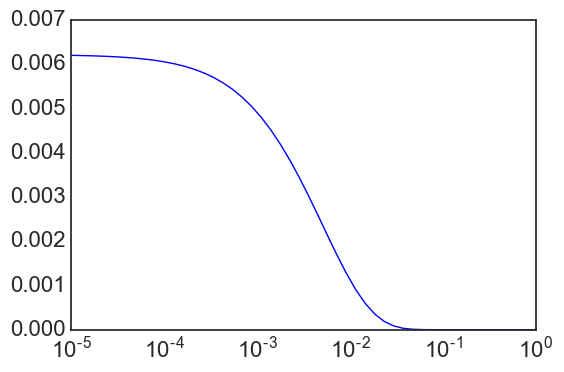

In [9]:
plt.semilogx(time,acf)

lets try the discrete one.  Here we assume that we have a $q_{min}$ and that $q^2=q_{x}^2+q_{y}^2$ where each $q_{x}=lq_{min}$ and $q_{y}=mq_{min}$ which results in $q_{lm}=q_{min}\sqrt{l^2+m^2}$

In [10]:
q_list=[np.sqrt(l**2+m**2) for l in range(0,4) for m in range(0,4)]

In [11]:
q_list=np.array(sorted(q_list)[1:])
print(q_list.size)
print(q_list)
q_list=q_list*qmin

15
[ 1.          1.          1.41421356  2.          2.          2.23606798
  2.23606798  2.82842712  3.          3.          3.16227766  3.16227766
  3.60555128  3.60555128  4.24264069]


In [12]:
def corrfct(t,q_list):
    corr=np.exp(-gamma(q_list)*t)/(kappa*q_list**4+sigma*q_list**2+ga)*avg(q_list,1e-6)*np.exp(-0.25*0.5**2*q_list**2)
    return corr.sum()

In [13]:
acf_d = np.array([corrfct(t,q_list) for t in time])

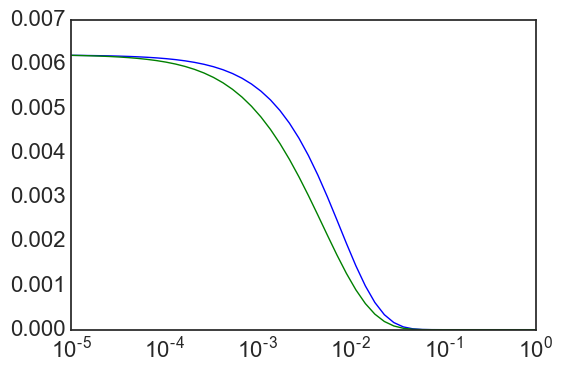

In [14]:
# plot correlation functions and normalize them to the same msd
plt.semilogx(time,acf_d*acf[0]/acf_d[0])
plt.semilogx(time,acf)

In [15]:
delta_t = 0.00001
def simulate_membrane(N):
    ts_all = None
    for q in q_list:
        ts = langevin.time_series2(1/(kappa*q**4+sigma*q**2+ga),gamma(q),delta_t,N)
    #    print(1/(kappa*q**4+sigma*q**2+ga),gamma(q))
        if ts_all is None:
            ts_all = ts
        else:
            ts_all = ts_all + ts
    return ts_all

ts_all=simulate_membrane(100000)

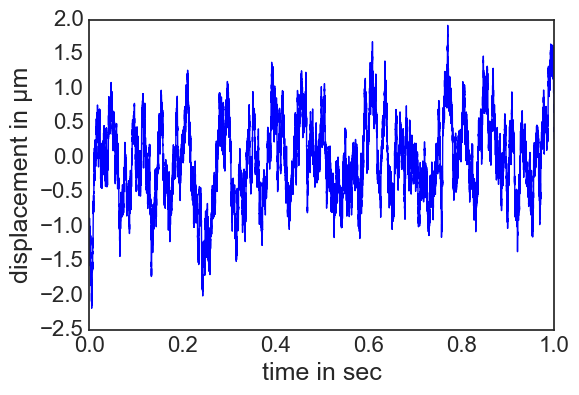

In [16]:
plt.plot(np.arange(ts_all.size)*delta_t,ts_all)
plt.xlabel("time in sec")
plt.ylabel("displacement in µm")
plt.savefig("membrane_ts300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

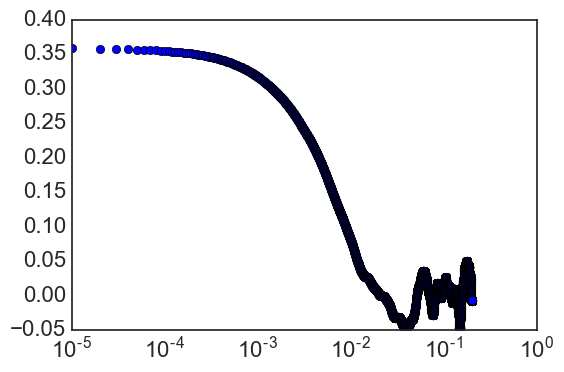

In [17]:
N = ts_all.size
# calculate autocorrelation function
f = np.fft.rfft(ts_all)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / N
autocorr = acf[int(N / 2):]

autocorr = autocorr[:20000]
t = np.arange(autocorr.size)*delta_t
plt.semilogx(t, autocorr,"o")

In [18]:
def fitcorr(t,kappa,sigma,ga,eta):
    corr=[np.sum(np.exp(-gamma(q_list,kappa=kappa, sigma=sigma, ga=ga, eta=eta)*tt)/(kappa*q_list**4+sigma*q_list**2+ga)) for tt in t]
    return corr

fit_corr_model=lm.Model(fitcorr)

[[Model]]
    Model(fitcorr)
[[Fit Statistics]]
    # function evals   = 19
    # data points      = 20000
    # variables        = 1
    chi-square         = 13.501
    reduced chi-square = 0.001
    Akaike info crit   = -146010.989
    Bayesian info crit = -146003.085
[[Variables]]
    kappa:   10 (fixed)
    sigma:   125 (fixed)
    ga:      25 (fixed)
    eta:     0.22270477 +/- 0.001391 (0.63%) (init= 0.25)
[[Correlations]] (unreported correlations are <  0.250)



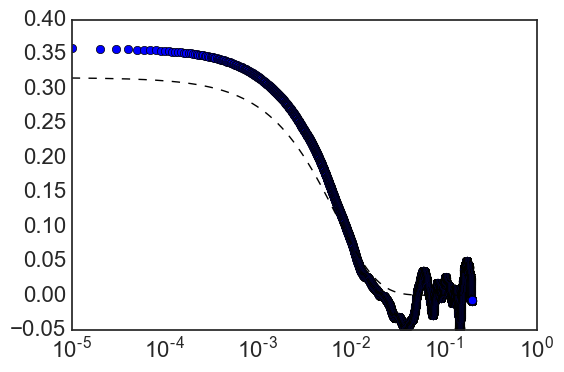

In [19]:
paramsFC = fit_corr_model.make_params()
paramsFC['kappa'].set(value=kappa,vary=False)
paramsFC['sigma'].set(value=sigma,vary=False)
paramsFC['ga'].set(value=ga,vary=False)
paramsFC['eta'].set(value=eta,vary=True)

resultFC = fit_corr_model.fit(t=t,data=autocorr,params=paramsFC)

plt.figure()
plt.semilogx(t,autocorr,"o")
plt.semilogx(t,resultFC.best_fit, 'k--')

print(resultFC.fit_report(min_correl=0.25))

In [20]:
gamma_list = []
gamma_std_list = []
N = 100000
for i in range(100):
    ts=simulate_membrane(N)
    # calculate autocorrelation function
    f = np.fft.rfft(ts)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]
    
    autocorr = autocorr[:20000]
    t = np.arange(autocorr.size)*delta_t

    # fit the autocorrelation function
    paramsFC = fit_corr_model.make_params()
    paramsFC['kappa'].set(value=kappa,vary=False)
    paramsFC['sigma'].set(value=sigma,vary=False)
    paramsFC['ga'].set(value=ga,vary=True)
    paramsFC['eta'].set(value=eta,vary=False)

    resultFC = fit_corr_model.fit(t=t,data=autocorr,params=paramsFC)

    gamma_list.append(np.abs(resultFC.values['ga']))
    gamma_std_list.append(resultFC.covar[0][0])
    print("done with..",i)
    
gamma_list = np.array(gamma_list)
gamma_std_list = np.array(gamma_std_list)

done with.. 0
done with.. 1
done with.. 2
done with.. 3
done with.. 4
done with.. 5
done with.. 6
done with.. 7
done with.. 8
done with.. 9
done with.. 10
done with.. 11
done with.. 12
done with.. 13
done with.. 14
done with.. 15
done with.. 16
done with.. 17
done with.. 18
done with.. 19
done with.. 20
done with.. 21
done with.. 22
done with.. 23
done with.. 24
done with.. 25
done with.. 26
done with.. 27
done with.. 28
done with.. 29
done with.. 30
done with.. 31
done with.. 32
done with.. 33
done with.. 34
done with.. 35
done with.. 36
done with.. 37
done with.. 38
done with.. 39
done with.. 40
done with.. 41
done with.. 42
done with.. 43
done with.. 44
done with.. 45
done with.. 46
done with.. 47
done with.. 48
done with.. 49
done with.. 50
done with.. 51
done with.. 52
done with.. 53
done with.. 54
done with.. 55
done with.. 56
done with.. 57
done with.. 58
done with.. 59
done with.. 60
done with.. 61
done with.. 62
done with.. 63
done with.. 64
done with.. 65
done with.. 66
done 

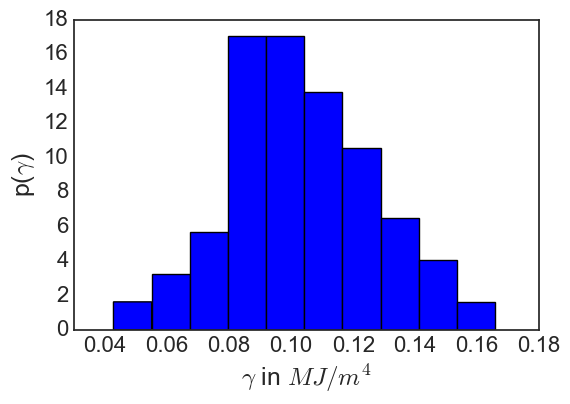

In [26]:
plt.hist(gamma_list*4/1000, normed=True)
plt.ylabel(r"p($\gamma$)")
plt.xlabel(r"$\gamma$ in $MJ/m^{4}$")
plt.xlim((0.03,0.18))
plt.savefig("membrane_gamma300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [22]:
print(gamma_std_list.mean(),gamma_list.std(),gamma_list.mean())

0.015344441572 5.92253333144 25.8802937742


In [23]:
print(4*gamma_std_list.mean(),4*gamma_list.std(),4*gamma_list.mean())

0.0613777662882 23.6901333257 103.521175097


In [24]:
print(gamma_list.std()/gamma_std_list.mean())

385.972555836


In [25]:
print(0.024/6e-5)

400.0
